# Tracking the traffic-aware paths

In [1]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, box_2d_center, PolygonRegion
from panav.hybrid import HybridGraph
from panav.viz import draw_hybrid

from panav.TrafficAwarePlanning import traffic_aware_HG_plan
from panav.SAMP import Tube_Planning

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

## Empty environment

In [121]:

# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 8,-8
start_x_offset = 6
goal_x_offset = 8
N = 2

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

# start = np.array(list(starts[0].centroid().coords)[0])
# goal = np.array(list(goals[0].centroid().coords)[0])

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 
env = NavigationEnv(limits,[],starts,goals)

# Multi-tunnel Environment

In [122]:
y_min,y_max = min(limits[1]),max(limits[1])
n_tunnel = 6
w = 2*bloating_r # Tunnel width
s = (y_max-y_min-w*n_tunnel)/(n_tunnel+1) # Spacing between tunnels

d = 5 # Thickness of the wall

obstacles = []
for i in range(n_tunnel+1):
    side = np.array([d,s])
    center = np.array([0, y_max-s/2-i*(s+w)])
    obstacles.append(box_2d_center(center,side))
env.obstacles = obstacles



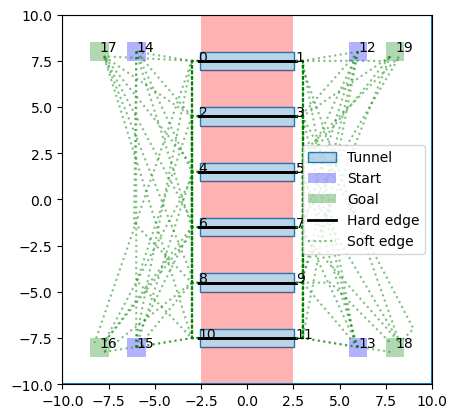

In [124]:
HG = HybridGraph(env,bloating_r)
ax = plt.gca()
draw_hybrid(HG,ax,display_soft=True,display_node=True)
plt.show()    


In [125]:
paths = traffic_aware_HG_plan(HG)

In [126]:
from panav.PBS.PBS_hybrid_SIPP import PBS_hybrid_SIPP
from panav.PBS.PBS import PBS
s2m2=PBS(HG.env,vmax,bloating_r,low_level_planner="Efficient_Tube_Planning")

AttributeError: 'NavigationEnv' object has no attribute 'start_locs'

In [107]:
vmax = 1.0
continuous_plans = []

from panav.SAMP import Efficient_Tube_Planning,auto_K_tube_planning,milestone_tracking

for i,path in enumerate(paths):
    print("Planning for {}/{}".format(i,len(paths)))
    start = HG.node_loc(path[0])
    goal = HG.node_loc(path[-1])
    
    # p = Efficient_Tube_Planning(HG.env,start,goal,vmax,bloating_r,continuous_plans)

    # p = auto_K_tube_planning(HG.env,start,goal,vmax,bloating_r,obs_trajectories=continuous_plans)
    
    milestones = [HG.node_loc(u) for u in path]
    p = milestone_tracking(HG.env,milestones,continuous_plans,vmax,bloating_r)

    continuous_plans.append(p)


Planning for 0/4
Planning for 1/4
Planning for 2/4
Planning for 3/4


In [76]:

def flowtime(plan):
    return np.sum([t[-1] for t,x in plan])
def makespan(plan):
    return np.max([t[-1] for t,x in plan])

In [108]:
flowtime(continuous_plans)

131.5353956248087

In [109]:
flowtime(s2m2[0])

123.03657781621034

In [71]:
continuous_plans

[(array([-0.     ,  2.40416,  4.41058, 11.85288, 12.72792, 32.59762]),
  array([[ 6.     ,  4.3    ,  2.88125, -2.38125, -3.     , -7.75   ],
         [ 8.     ,  6.3    ,  6.3    ,  6.3    ,  6.3    , -7.75   ]])),
 (array([-0.     ,  0.80139,  4.41058, 11.85288, 12.72792, 19.44544]),
  array([[ 6.     ,  5.43333,  2.88125, -2.38125, -3.     , -7.75   ],
         [ 2.66667,  2.1    ,  2.1    ,  2.1    ,  2.1    , -2.41667]])),
 (array([-0.     ,  0.80139,  4.41058, 11.85288, 14.30105, 21.01857]),
  array([[ 6.     ,  5.43333,  2.88125, -2.38125, -3.     , -7.75   ],
         [-2.66667, -2.1    , -2.1    , -2.1    , -2.1    ,  2.41667]])),
 (array([-0.     ,  2.40416,  4.41058, 11.85288, 16.96995, 36.83965]),
  array([[ 6.     ,  4.3    ,  2.88125, -2.38125, -3.     , -7.75   ],
         [-8.     , -6.3    , -6.3    , -6.3    , -6.3    ,  7.75   ]])),
 (array([-0.     ,  2.40416,  4.41058, 14.30105, 25.05756, 25.9326 ,
         45.8023 ]),
  array([[-6.     , -4.3    , -2.88125, -5.224

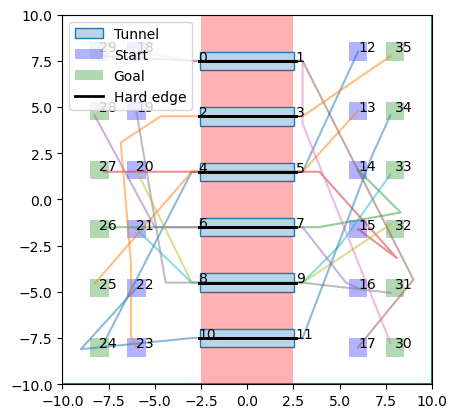

In [101]:
draw_hybrid(HG,ax=plt.gca(),paths = [o[1] for o in continuous_plans if o])